# Paper replicating

## 0. Get setup

In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3070


In [2]:
import os
import zipfile
import urllib.request
import shutil
from pathlib import Path

# Define the URL of the repository in zip format
url = "https://github.com/mrdbourke/pytorch-deep-learning/archive/refs/heads/main.zip"
zip_filename = "pytorch-deep-learning.zip"
extract_dir = "pytorch-deep-learning-main"
scripts_path = Path("going_modular")

# If the scripts folder doesn't exist, download and prepare it...
if scripts_path.is_dir():
    print(f"{scripts_path} directory exists.")
else:
    # Download the zip file from the URL
    print(f"[INFO] Downloading {url}...")
    urllib.request.urlretrieve(url, zip_filename)

    # Unzip the downloaded file
    print(f"[INFO] Unzipping {zip_filename}...")
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall()

    # Move the necessary files to the working directory
    print("[INFO] Moving necessary files...")

    # Move the going_modular folder
    shutil.move(os.path.join(extract_dir, "going_modular"), ".")

    # Move the helper_functions.py file
    shutil.move(os.path.join(extract_dir, "helper_functions.py"), ".")

    # Remove unnecessary files and folders
    print(f"[INFO] Removing temporary files...")
    os.remove(zip_filename)  # Delete the zip file
    shutil.rmtree(extract_dir)  # Delete the extracted directory

    print("[INFO] Download and extraction completed.")

going_modular directory exists.


## 1. Get the data

In [3]:
import os
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "sidd_small_dataset/SIDD_Small_sRGB_Only/Data"

# SIDD Small Dataset URL
url = "https://competitions.codalab.org/my/datasets/download/a26784fe-cf33-48c2-b61f-94b299dbc0f2"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
        
    # Download sidd small dataset
    with open(data_path / "sidd_small_dataset.zip", "wb") as f:
        request = requests.get(url)
        print(f"Downloading sidd small dataset...")
        f.write(request.content)

    # Unzip sidd small dataset
    with zipfile.ZipFile(data_path / "sidd_small_dataset.zip", "r") as zip_ref:
        print(f"Unzipping sidd small dataset...") 
        zip_ref.extractall(image_path)
        
    # Remove .zip file
    os.remove(data_path / "sidd_small_dataset.zip")

data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data directory exists.


In [4]:
# Listas para almacenar los paths de las imágenes GT y Noisy
image_gt_path_list = []
image_noisy_path_list = []

# Recorremos todas las carpetas
for folder in image_path.iterdir():
    if folder.is_dir():  # Asegurarnos de que sea una carpeta
        # Buscar la imagen GT
        gt_image = folder / "GT_SRGB_010.PNG"
        # Buscar la imagen Noisy
        noisy_image = folder / "NOISY_SRGB_010.PNG"
        
        # Verificar si ambas imágenes existen en la carpeta
        if gt_image.exists() and noisy_image.exists():
            # Añadir los paths a las listas correspondientes
            image_gt_path_list.append(gt_image)
            image_noisy_path_list.append(noisy_image)

# Mostramos los primeros 5 paths de cada lista para verificar
print("GT Image Paths:", image_gt_path_list[:5])
print("Noisy Image Paths:", image_noisy_path_list[:5])
print(f"GT Image Paths size: {len(image_gt_path_list)}")
print(f"Noisy Image Paths size: {len(image_noisy_path_list)}")

GT Image Paths: [PosixPath('data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0140_006_IP_00800_00800_3200_L/GT_SRGB_010.PNG'), PosixPath('data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/GT_SRGB_010.PNG'), PosixPath('data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0094_005_N6_00100_00050_3200_L/GT_SRGB_010.PNG'), PosixPath('data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0149_007_G4_00800_00800_4400_L/GT_SRGB_010.PNG'), PosixPath('data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0126_006_S6_00400_00200_4400_L/GT_SRGB_010.PNG')]
Noisy Image Paths: [PosixPath('data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0140_006_IP_00800_00800_3200_L/NOISY_SRGB_010.PNG'), PosixPath('data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/NOISY_SRGB_010.PNG'), PosixPath('data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0094_005_N6_00100_00050_3200_L/NOISY_SRGB_010.PNG'), PosixPath('data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0149_

## 2. Create Datasets and Dataloaders

In [5]:
import os
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Definimos el dataset customizado para SIDD
class SIDDImageDataset(Dataset):
    def __init__(self, gt_paths, noisy_paths, transform=None):
        self.gt_paths = gt_paths
        self.noisy_paths = noisy_paths
        self.transform = transform

    def __len__(self):
        return len(self.gt_paths)

    def __getitem__(self, idx):
        # Cargar imágenes
        img_gt = Image.open(self.gt_paths[idx])
        img_noisy = Image.open(self.noisy_paths[idx])

        # Aplicar transformaciones si están definidas
        if self.transform:
            img_gt = self.transform(img_gt)
            img_noisy = self.transform(img_noisy)

        return img_gt, img_noisy  # Devolvemos la imagen gt y su correspondiente imagen con ruido

# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar imagen a (224, 224) 
    transforms.ToTensor(),  # Convertir a tensor en el rango [0, 1]
])

# Crear el dataset
dataset = SIDDImageDataset(image_gt_path_list, image_noisy_path_list, transform=transform)

# Crear el DataLoader con un batch size de 32 imágenes
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Probar una iteración
gt_batch, noisy_batch = next(iter(dataloader))
print(f"Batch de imágenes ruidosas: {noisy_batch.shape}")
print(f"Batch de imágenes GT: {gt_batch.shape}")

Batch de imágenes ruidosas: torch.Size([32, 3, 224, 224])
Batch de imágenes GT: torch.Size([32, 3, 224, 224])


## 3. Visualize random images

82
Random image path: data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0194_009_IP_01600_04000_3200_N/GT_SRGB_010.PNG
Image height: 3024
Image width: 4032

Random image path: data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0194_009_IP_01600_04000_3200_N/NOISY_SRGB_010.PNG
Image height: 3024
Image width: 4032


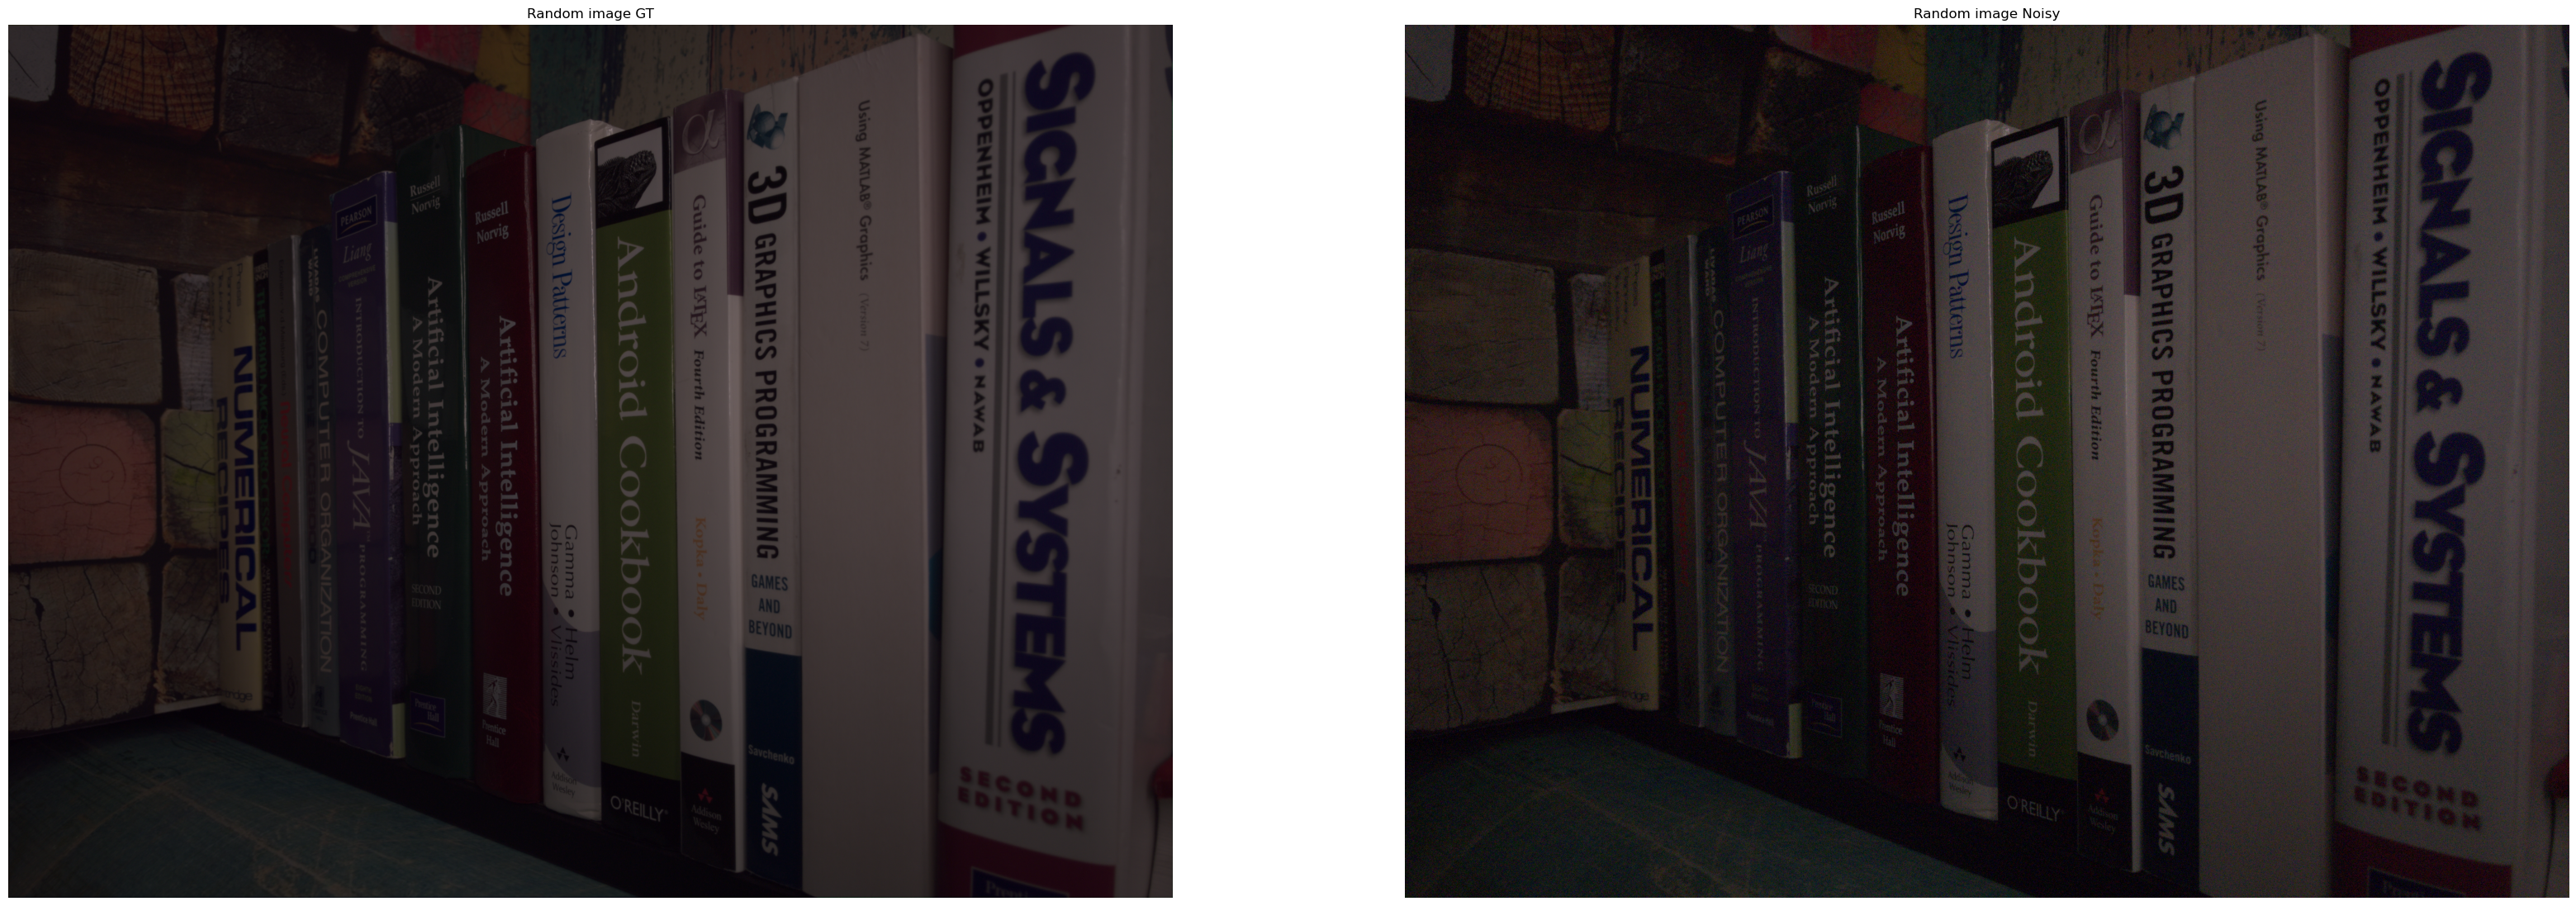

In [6]:
import random
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

# Set seed
# random.seed(42) # <- try changing this and see what happens
random_int = random.randint(0, 159)
print(random_int)

# Get random image path
random_image_gt_path = image_gt_path_list[random_int]
random_image_noisy_path = image_noisy_path_list[random_int]

# Open image
random_img_gt = Image.open(random_image_gt_path)
random_img_noisy = Image.open(random_image_noisy_path)

# Print metadata
print(f"Random image path: {random_image_gt_path}")
print(f"Image height: {random_img_gt.height}") 
print(f"Image width: {random_img_gt.width}\n")

# Print metadata
print(f"Random image path: {random_image_noisy_path}")
print(f"Image height: {random_img_noisy.height}") 
print(f"Image width: {random_img_noisy.width}")

# Visualize images
fig, axs = plt.subplots(1, 2, figsize=(40, 36))

# Image GT
axs[0].imshow(random_img_gt)
axs[0].set_title("Random image GT")
axs[0].axis(False)

# Image Noisy
axs[1].imshow(random_img_noisy)
axs[1].set_title("Random image Noisy")
axs[1].axis(False);

## 4. Replicating ViT

### 4.1. Get images from dataloader

In [7]:
# Get a single image from the batch
image = noisy_batch[5]

# View the single image and label shapes
image.shape

torch.Size([3, 224, 224])

### 4.2. Turning a simple image into patches

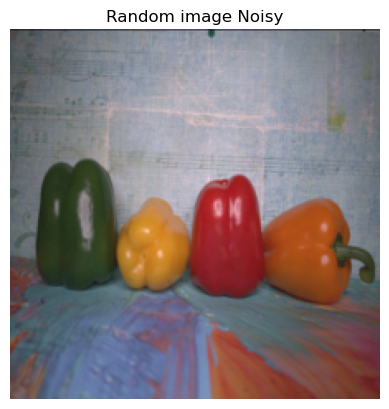

In [8]:
import matplotlib.pyplot as plt

# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title("Random image Noisy")
plt.axis(False);

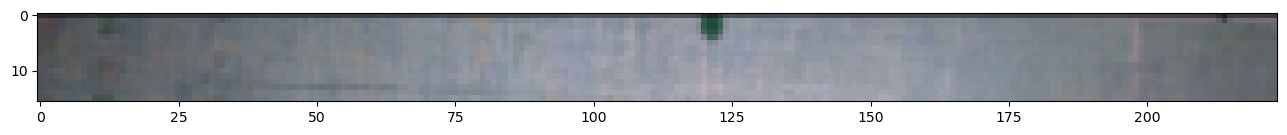

In [9]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # convert image to color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


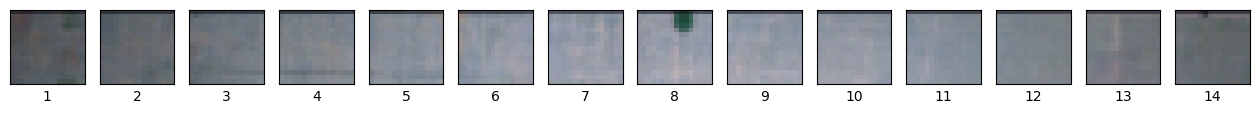

In [10]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(
    nrows=1,
    ncols=img_size//patch_size, # one column for each patch
    sharex=True,
    sharey=True,
    figsize=(patch_size, patch_size)
)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1)  # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0  
Number of patches per column: 14.0  
Total patches: 196.0  
Patch size: 16 pixels x 16 pixels


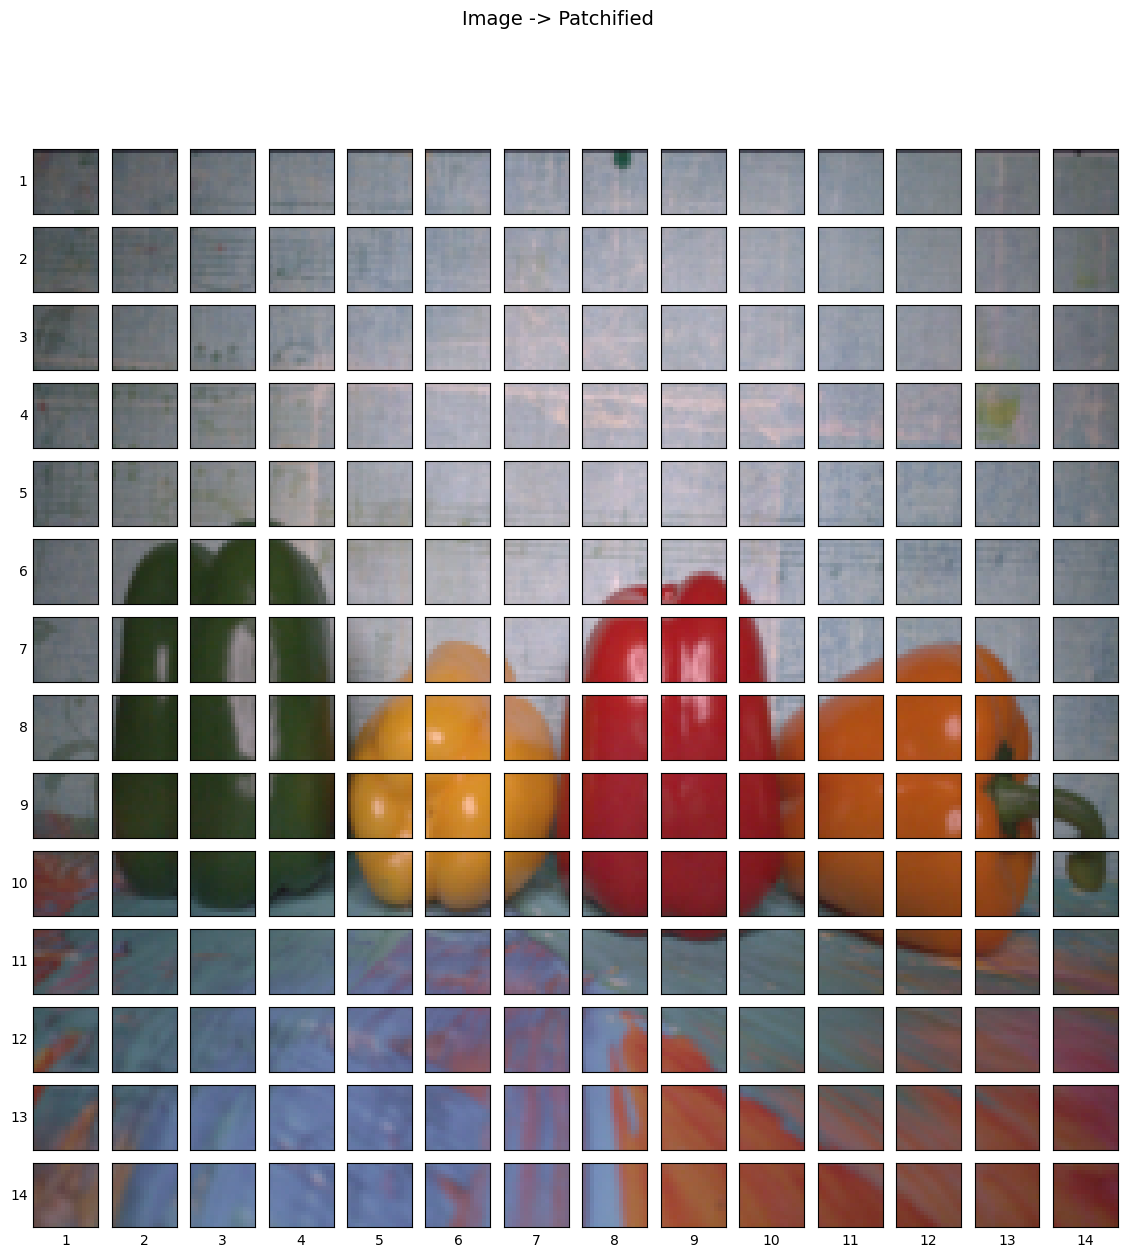

In [11]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
  \nNumber of patches per column: {num_patches}\
  \nTotal patches: {num_patches*num_patches}\
  \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(
    nrows=img_size//patch_size,
    ncols=img_size//patch_size,
    figsize=(num_patches, num_patches),
    sharex=True,
    sharey=True
)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # Plot the permuted image on the different axes
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                    patch_width:patch_width+patch_size, # iterate through width
                                    :]) # get all color channels
    # Set up label information for each subplot (patch)
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set up a title for the plot
fig.suptitle(f"Image -> Patchified", fontsize=14)
plt.show()

### 4.3. Creating image patches and turning them into patch embeddings

In [12]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(
    in_channels=3,  # for color images
    out_channels=768, # D size from Table 1 for ViT-Base
    kernel_size=patch_size,
    stride=patch_size,
    padding=0
)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

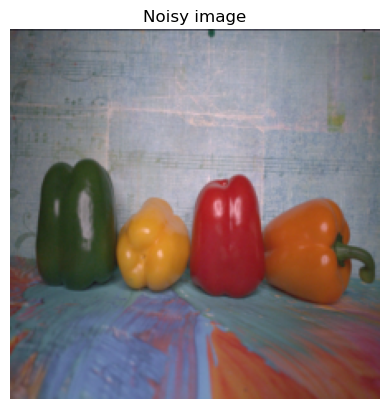

In [13]:
# Visualize single image
plt.imshow(image.permute(1, 2, 0))
plt.title("Noisy image")
plt.axis(False);

In [14]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0))  # add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [15]:
image_out_of_conv.requires_grad

True

Now we've passed a single image to our `conv2d` layer, it's shape is:

```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional feature maps from indexes: [546, 460, 18, 750, 664]


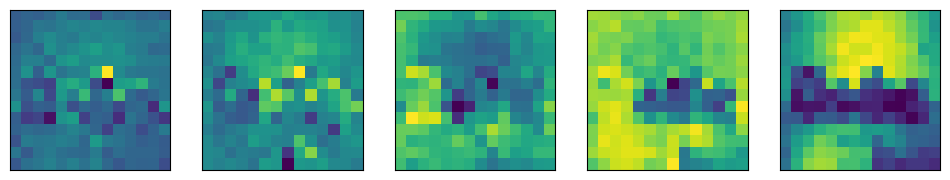

In [16]:
# Plot random convolutional feature maps (embeddings)
import random

random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(
    nrows=1,
    ncols=5,
    figsize=(12, 12)
)

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :]  # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())  # remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [17]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.2495, -0.2951, -0.3676, -0.4085, -0.4388, -0.4836, -0.5150,
           -0.4630, -0.4703, -0.4858, -0.4406, -0.4099, -0.3730, -0.3269],
          [-0.2669, -0.3221, -0.3823, -0.4187, -0.4744, -0.5086, -0.5035,
           -0.5483, -0.5670, -0.5598, -0.5131, -0.4650, -0.4105, -0.3438],
          [-0.2965, -0.3524, -0.3987, -0.4548, -0.4928, -0.5479, -0.5874,
           -0.5991, -0.5992, -0.5880, -0.5385, -0.4857, -0.4273, -0.3732],
          [-0.3196, -0.3670, -0.4382, -0.5100, -0.5554, -0.5758, -0.5765,
           -0.6241, -0.6425, -0.6142, -0.5081, -0.5072, -0.4380, -0.4114],
          [-0.2898, -0.3738, -0.4430, -0.4919, -0.5233, -0.5658, -0.5947,
           -0.6176, -0.5980, -0.5947, -0.5616, -0.4801, -0.4501, -0.4004],
          [-0.3487, -0.2789, -0.1502, -0.2452, -0.5342, -0.5714, -0.6194,
           -0.5696, -0.2983, -0.4828, -0.5382, -0.4842, -0.4459, -0.3874],
          [-0.3309, -0.1873, -0.2717, -0.2036, -0.5229, -0.4349, -0.6006,
           -0.1328, -0.2707, -0.

### 4.4. Flattening the patch embedding with `torch.nn.Flatten()`

In [18]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


In [19]:
from torch import nn

flatten_layer = nn.Flatten(
    start_dim=2,
    end_dim=3
)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


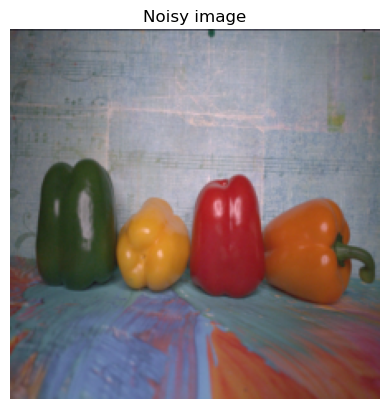

In [20]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title("Noisy image")
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))  # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [21]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


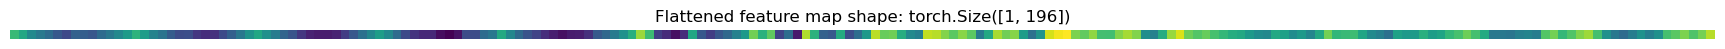

In [22]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

### 4.5. Turning the ViT patch embedding layer into a PyTorch module

In [23]:
# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  # 2. Initilaize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): # from Table 1 for ViT-Base
    super().__init__()

    self.patch_size = patch_size
  
    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    
    # 4. Create a layer to flatten feature map outputs of Conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)
    
  # 5. Define a forward method to define the forward computation steps
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x) 
    x_flattened = self.flatten(x_patched)
    # 6. Make the returned sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimension)
    return x_flattened.permute(0, 2, 1)

In [24]:
from helper_functions import set_seeds

set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


### 4.6. Creating the class token embedding

In [25]:
patch_embedded_image

tensor([[[-0.4103,  0.1009, -0.1043,  ...,  0.2807, -0.1300,  0.1178],
         [-0.4806,  0.0925, -0.1295,  ...,  0.3077, -0.1672,  0.1418],
         [-0.5515,  0.1501, -0.1353,  ...,  0.3324, -0.1911,  0.1498],
         ...,
         [-0.4210,  0.0458, -0.0364,  ...,  0.2286, -0.2070,  0.1487],
         [-0.3544, -0.0008, -0.0580,  ...,  0.2217, -0.1809,  0.1526],
         [-0.3055, -0.0060, -0.0674,  ...,  0.1659, -0.1703,  0.1635]]],
       grad_fn=<PermuteBackward0>)

In [26]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [27]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [28]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [29]:
# Add the class token embedding to the front of the patch embedding 
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # number_of_patches dimension

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-4.1032e-01,  1.0088e-01, -1.0428e-01,  ...,  2.8074e-01,
          -1.3002e-01,  1.1782e-01],
         [-4.8057e-01,  9.2533e-02, -1.2951e-01,  ...,  3.0769e-01,
          -1.6719e-01,  1.4181e-01],
         ...,
         [-4.2098e-01,  4.5793e-02, -3.6380e-02,  ...,  2.2863e-01,
          -2.0695e-01,  1.4873e-01],
         [-3.5442e-01, -7.6673e-04, -5.8047e-02,  ...,  2.2170e-01,
          -1.8087e-01,  1.5258e-01],
         [-3.0546e-01, -6.0472e-03, -6.7419e-02,  ...,  1.6586e-01,
          -1.7028e-01,  1.6354e-01]]], grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


### 4.7. Creating the position embedding

In [31]:
height = 224
width = 224

# Calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [32]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00],
          [-4.1032e-01,  1.0088e-01, -1.0428e-01,  ...,  2.8074e-01,
           -1.3002e-01,  1.1782e-01],
          [-4.8057e-01,  9.2533e-02, -1.2951e-01,  ...,  3.0769e-01,
           -1.6719e-01,  1.4181e-01],
          ...,
          [-4.2098e-01,  4.5793e-02, -3.6380e-02,  ...,  2.2863e-01,
           -2.0695e-01,  1.4873e-01],
          [-3.5442e-01, -7.6673e-04, -5.8047e-02,  ...,  2.2170e-01,
           -1.8087e-01,  1.5258e-01],
          [-3.0546e-01, -6.0472e-03, -6.7419e-02,  ...,  1.6586e-01,
           -1.7028e-01,  1.6354e-01]]], grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [33]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5897, 1.1009, 0.8957,  ..., 1.2807, 0.8700, 1.1178],
         [0.5194, 1.0925, 0.8705,  ..., 1.3077, 0.8328, 1.1418],
         ...,
         [0.5790, 1.0458, 0.9636,  ..., 1.2286, 0.7930, 1.1487],
         [0.6456, 0.9992, 0.9420,  ..., 1.2217, 0.8191, 1.1526],
         [0.6945, 0.9940, 0.9326,  ..., 1.1659, 0.8297, 1.1635]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


### 4.8. Putting it all together: from image to embedding

In [34]:
# Set seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size, 
                                       embedding_dim=768)

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape} ")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768]) 


## 5. Equation 2: Multihead Self-Attention (MSA block)

In [35]:
class MultiHeadSelfAttentionBlock(nn.Module): 
  """Creates a multi-head self-attention block ("MSA block" for short).
  """
  def __init__(self, 
               embedding_dim:int=768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
               num_heads:int=12, # Heads from Table 1 for ViT-Base
               attn_dropout:int=0):
    super().__init__()
    
    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout, 
                                                batch_first=True) # is the batch first? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)
  
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)
    return attn_output

In [36]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## 6. Equation 3: Multilayer Perceptron (MLP block)

In [38]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()
    
    # Create the norm layer (LN) 
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout) 
    )
  
  def forward(self, x):
    x = self.layer_norm(x) 
    x = self.mlp(x)
    return x

In [39]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


## 7. Creating the Transformer Encoder

### 7.1. Create a custom Transformer Encoder block

In [40]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # Hidden size D from table 1, 768 for ViT-Base
               num_heads:int=12, # from table 1
               mlp_size:int=3072, # from table 1
               mlp_dropout:int=0.1, # from table 3
               attn_dropout:int=0):
    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)
    
    # Create MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim, 
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)
    
  def forward(self, x):
    x = self.msa_block(x) + x # residual/skip connection for equation 2
    x = self.mlp_block(x) + x # residual/skip connection for equation 3
    return x 

In [41]:
from torchinfo import summary

# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2. Create a Transformer Encoder layer with in-built PyTorch layers

In [42]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding size from table 1
                                                             nhead=12, # heads from table 1
                                                             dim_feedforward=3072, # MLP size from table
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [43]:
# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## 8. Putting it all together to create ViT

In [47]:
# Create a ViT class 
class ViT(nn.Module): 
  def __init__(self,
               img_size:int=224, # Table 3 from the ViT paper
               in_channels:int=3,
               patch_size:int=16, 
               num_transformer_layers:int=12, # Table 1 for "Layers" for ViT-Base
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072, # Table 1
               num_heads:int=12, # Table 1
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1): # Dropout for patch and position embeddings
            #    num_classes:int=1000: # number of classes in our classification problem
    super().__init__()

    # Make an assertion that the image size is compatible with the patch size
    assert img_size % patch_size == 0,  f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

    # Calculate the number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)
    
    # Create learnable position embedding 
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)
    
    # Create the Transformer Encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    
    # # Create classifier head
    # self.classifier = nn.Sequential(
    #     nn.LayerNorm(normalized_shape=embedding_dim),
    #     nn.Linear(in_features=embedding_dim,
    #               out_features=num_classes)
    # )
  
  def forward(self, x):
    # Get the batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions
    
    # Create the patch embedding (equation 1)
    x = self.patch_embedding(x)
    
    # Concat class token embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches, embedding_dim)

    # Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # Apply dropout to patch embedding ("directly after adding positional- to patch embeddings")
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to Transformer Encoder (equation 2 & 3)
    x = self.transformer_encoder(x)

    # Put 0th index logit through classifier (equation 4)
    # x = self.classifier(x[:, 0])
    
    return x 

In [48]:
batch_size=32
embedding_dim=768
class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                              requires_grad=True)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
print(class_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [49]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak and sushi)
vit = ViT()

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[[-0.1437, -0.0493,  0.4001,  ..., -0.2627,  1.9916,  2.7693],
         [ 1.8520,  0.2045, -0.3777,  ..., -1.0872,  1.0972,  2.5803],
         [-1.1767, -2.5573,  1.4078,  ..., -0.8654,  2.0423,  0.9565],
         ...,
         [-0.9107,  1.4681,  0.9730,  ...,  0.2376, -1.2550,  0.4460],
         [ 0.7697,  2.6614,  1.0458,  ...,  0.9920,  2.1526,  0.8102],
         [-1.1118,  1.3128, -1.0961,  ..., -1.8409,  0.1372, -0.5061]]],
       grad_fn=<AddBackward0>)

### 8.1. Getting a visual summary of our ViT model

In [52]:
from torchinfo import summary

summary(model=ViT(),
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 197, 768]        152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 